In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../scripts') 

from qutip_tools import *


In [11]:
# define basic figure sizes
bwidth=7.5
bheight=5
base_font = 30

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-5 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/for_poster/"


In [12]:
data_route = "../data/sims/L=21/"
J=1

In [13]:
def get_partial_trace(Psi, NN):
    # calcualtes the partial trace from a STATEVECTOR Psi
    # NOT from the density matrix
    # Psi: Quobject from Qutip representing the wavefunction
    # NN: integer with the total size of the lattice

    n = 2 ** (NN - 2)  # QPC sites
    m = 2 ** 2  # Double dot sites
    # get density matrix as a sparse array
    ps = sparse.csr_matrix(Psi.full())
    A = sparse.kron(ps, np.conj(ps.T))
    # convert to normal array for partial trace operation
    Adense = A.toarray()
    # trace out QPC sites and return reduced rho for DD as Quobject
    return Qobj(np.trace(Adense.reshape(n, m, n, m), axis1=0, axis2=2))



def get_file_names_on(param_list, route):
    name_list = os.listdir(route)
    try:
        name_list.remove('.DS_Store')
    except:
        pass
    # gets a list of the hdf5 file names with t dependent data depending on the values in param_list
    for subs in param_list:
        # getting strings with parameters that we want
        name_list = list(filter(lambda x: subs in x, name_list))
    return name_list

In [14]:
data_full_df = pd.read_csv('../data/exp_pro/exploration_data_L=21.csv')
data_full_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_full_df = data_full_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()

print("Number of data points:", len(data_full_df))
print(data_full_df.columns)
data_full_df.head()


Number of data points: 1398
Index(['L_qpc', 'max_time', 'tsteps', 'bond_index', 'x_spread', 'k0',
       'J_prime', 't', 'Omega', 'vg', 'time_at_bond', 'bond_fit_error',
       'time_f_free', 'time_f_int', 'xf_avg_free', 'xf_avg_int',
       'Transmision_tot', 'Transmission_k0', 'r_density_free', 'r_density_int',
       'last_density_free', 'last_density_int', 'last_density_max',
       'time_last_density_max', 'bond_density_max', 'min_purity',
       'max_VN_entropy', 'entanglement_timeskip', 'T_mean', 'ddot0', 'kick',
       'theta_f', 'phi_f', 'delta_phi', 'dd_density_hit'],
      dtype='object')


,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick,theta_f,phi_f,delta_phi,dd_density_hit
0,21,18.0,400,7,0.5,0.392699,1.0,0.0,0.40,0.765367,...,1.000000,8.992806e-15,10,0.951081,fixed,0.564233,2.107342e-08,0.000000,1.570796,1.000000
1,21,18.0,400,7,0.5,0.981748,1.0,0.4,0.01,1.662939,...,0.999962,2.238491e-04,10,0.802858,fixed,0.012193,2.895775e+00,1.535108,0.035688,0.030646
2,21,18.0,400,7,2.0,0.392699,1.0,0.2,0.50,0.765367,...,0.902862,2.020031e-01,10,0.827560,fixed,0.834754,1.550818e+00,-1.090803,2.661600,0.547722
3,21,18.0,400,7,0.5,0.981748,1.0,0.1,0.05,1.662939,...,0.998104,7.552377e-03,10,0.801953,fixed,0.060610,2.291796e+00,1.488497,0.082299,0.883334
4,21,18.0,400,7,2.0,0.392699,1.0,0.3,0.10,0.765367,...,0.994725,1.833645e-02,10,0.872464,fixed,0.171816,6.310212e-01,1.405248,0.165548,0.243214


In [15]:
data_full_df[data_full_df["time_f_int"]<0].describe()
data_full_df = data_full_df[data_full_df["vg"]>0]

# here we can choose wether we want just the "fixed" by k0 initial conditions
# or the fully localized "second"
data_df = data_full_df[data_full_df["ddot0"]=="fixed"]


In [16]:
print(data_df.columns)

print("omega")
print(data_df['Omega'].unique())
print("t")
print(data_df['t'].unique())
print(data_df['k0'].unique())

Index(['L_qpc', 'max_time', 'tsteps', 'bond_index', 'x_spread', 'k0',
       'J_prime', 't', 'Omega', 'vg', 'time_at_bond', 'bond_fit_error',
       'time_f_free', 'time_f_int', 'xf_avg_free', 'xf_avg_int',
       'Transmision_tot', 'Transmission_k0', 'r_density_free', 'r_density_int',
       'last_density_free', 'last_density_int', 'last_density_max',
       'time_last_density_max', 'bond_density_max', 'min_purity',
       'max_VN_entropy', 'entanglement_timeskip', 'T_mean', 'ddot0', 'kick',
       'theta_f', 'phi_f', 'delta_phi', 'dd_density_hit'],
      dtype='object')
omega
[0.4  0.01 0.5  0.05 0.1  0.   0.7  0.3  0.2 ]
t
[0.   0.4  0.2  0.1  0.3  0.01 0.8  0.5  0.7  0.6  0.9  0.05 1.  ]
[0.39269908 0.9817477  1.37444679 1.17809725 1.57079633 0.78539816
 0.52359878]


In [17]:
# defining our parameters
L_=21
Om_ = 0.3
Deltax_ = 2.0


# Phase Diagram

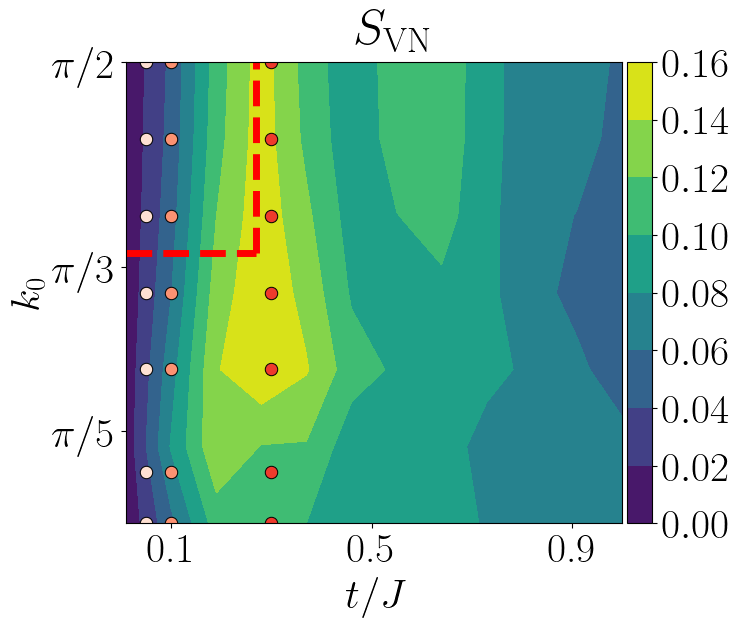

In [228]:
cond = (data_df["Omega"] == 0.3) & (data_df["x_spread"]==2.0) & (data_df["t"]>0)

S_df = data_df[cond].pivot(index="k0", columns="t", values="max_VN_entropy")

fig, ax = plt.subplots(1,1,figsize=(bwidth+0.6,bwidth))

plt.suptitle(r"$S_{\rm{VN}}$" , y=0.87, x=0.53)

vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(S_df.values, extent=[min(t_array), max(t_array),min(vg_array), max(vg_array)], 
                cmap="viridis")

# Putting the scatterplot points
t_ = 0.05
c = red_p[0]
cond = (data_df['t']==t_) & \
        (data_df["x_spread"] == Deltax_) & (data_df["Omega"] == Om_)

sns.scatterplot(data = data_df[cond], y="k0" ,x="t",color=c ,edgecolor='black' ,s=80,ax=ax)

t_ = 0.1
c = red_p[2]
cond = (data_df['t']==t_) & \
        (data_df["x_spread"] == Deltax_) & (data_df["Omega"] == Om_)

sns.scatterplot(data = data_df[cond], y="k0" ,x="t",color=c ,edgecolor='black' ,s=80,ax=ax)

t_ = 0.3
c = red_p[4]
cond = (data_df['t']==t_) & \
        (data_df["x_spread"] == Deltax_) & (data_df["Omega"] == Om_)

sns.scatterplot(data = data_df[cond], y="k0" ,x="t",color=c ,edgecolor='black' ,s=80,ax=ax)

ax.hlines(y=0.69*np.pi/2, xmin=0.01, xmax=0.27, linewidth=5, color='red', linestyle="dashed")

ax.vlines(x=0.27, ymin=0.69*np.pi/2, ymax=np.pi/2, linewidth=5, color='red', linestyle="dashed")


# labels and colorbars
ax.set_ylabel(r"$k_0$")
ax.set_xlabel(r"$t/J$")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05, )
cbar = fig.colorbar(im, cax, shrink=0.9)   

ax.set_xticks( [0.1,0.5,0.9], [0.1,0.5,0.9] )
ax.set_yticks( [np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"] )

# write x axis in units of pi

#"""ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
#                                                             r'{:.2f}$\pi$'.format(val/np.pi) if val !=0 
#                                                             else '0'))"""

plt.tight_layout()

plt.savefig(fig_route+"entropy_phase_diagram_L_={}_bw={}om={}.pdf".format(L_, Deltax_, Om_), transparent=True)

# Other Entropy graphs

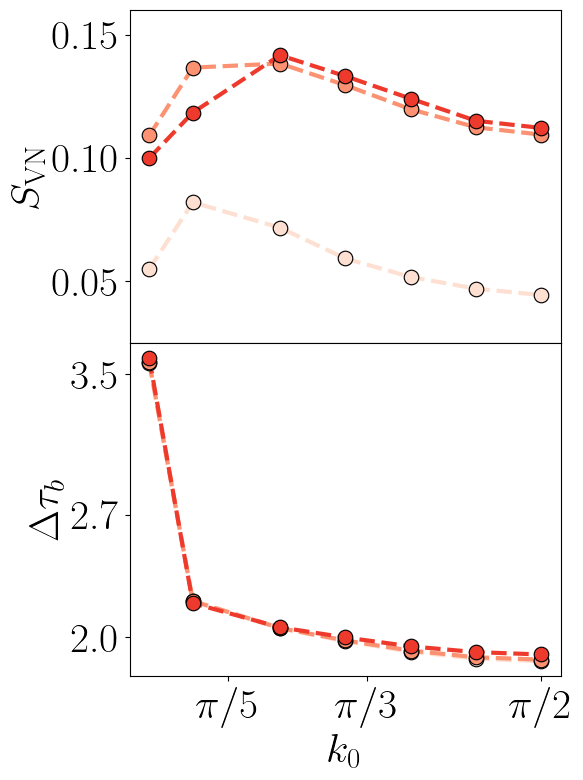

In [250]:
fig, ax = plt.subplots(2,1,figsize=(bwidth-1.0,1.7*bheight), sharex= True)
red_p = sns.color_palette(palette='Reds', n_colors=7)
t_list = [0.05, 0.1 ,0.3]

for i in range(0,len(t_list)):
    c = red_p[2*i]
    cond = (data_df['t']==t_list[i]) & \
            (data_df["x_spread"] == Deltax_) & (data_df["Omega"] == Om_)
    sns.scatterplot(data = data_df[cond], x="k0" ,y="max_VN_entropy",color=c ,
                   edgecolor='black' ,s=110,ax=ax[0])
    
    sns.lineplot(data = data_df[cond], x="k0" ,y="max_VN_entropy",color=c ,ax=ax[0],zorder=0, linewidth=3 ,linestyle="dashed")
    
    sns.scatterplot(data = data_df[cond], x="k0" ,y="time_at_bond",color=c , edgecolor='black' ,s=110,ax=ax[1])
    sns.lineplot(data = data_df[cond], x="k0" ,y="time_at_bond",color=c ,ax=ax[1],zorder=0, linewidth=3 ,linestyle="dashed")

ax[0].set_ylabel(r"$S_{\rm{VN}}$")
ax[0].set_ylim(0.025,0.16)
ax[0].set_yticks( [0.05,0.10,0.15],[0.05,"0.10",0.15]  )

# ax[0].legend(title="t", loc='center left', bbox_to_anchor=(1, 0.0),borderpad=0.2)

ax[1].set_xlabel(r"$k_0$")
ax[1].set_ylabel(r"$\Delta\tau_{b}$")
ax[1].set_yticks( [2, 2.7, 3.5],[2.0, 2.7, 3.5] )
ax[1].set_xticks( [np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"] )

plt.tight_layout()
fig.subplots_adjust(hspace=0.)

plt.savefig(fig_route+"entropy_time_k0_L_={}_bw={}om={}.pdf".format(L_, Deltax_, Om_), transparent=True)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(bwidth-0.7,bheight))

for i in range(0,len(t_list)):
    c = red_p[2*i]
    cond = (data_df['t']==t_list[i]) & \
            (data_df["x_spread"] == Deltax_) & (data_df["Omega"] == Om_)
    sns.scatterplot(data = data_df[cond], x="k0" ,y="max_VN_entropy",color=c , edgecolor='black' ,s=110,ax=ax)
    


ax.set_xlabel(r"$k_0$")
ax.set_ylabel(r"$S_{\rm{VN}}$")
ax.set_ylim(0.01,0.2)


#write x axis in units of pi
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.2f}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))
plt.tight_layout()

# plt.savefig(fig_route+"entropy_k0_L_={}_bw={}om={}.pdf".format(L_, Deltax_, Om_), transparent=True)

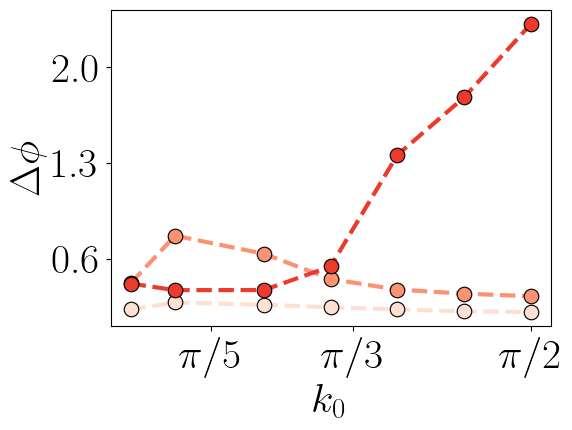

In [260]:
fig, ax = plt.subplots(1,1,figsize=(bwidth-1.1,bheight))

for i in range(0,len(t_list)):
    c = red_p[2*i]
    cond = (data_df['t']==t_list[i]) & \
            (data_df["x_spread"] == Deltax_) & (data_df["Omega"] == Om_)
    sorted_df = data_df[cond].sort_values(by="k0")

    sns.scatterplot(data = data_df[cond], x="k0" ,y="delta_phi",color=c ,edgecolor='black' ,s=110, ax=ax)
    sns.lineplot(data = data_df[cond], x="k0" ,y="delta_phi",color=c ,ax=ax,zorder=0, linewidth=3 ,linestyle="dashed")

plt.ylabel(r"$\Delta\phi$")
plt.xlabel(r"$k_0$")
ax.set_yticks( [0.6, 1.3, 2.0],[0.6, 1.3, 2.0] )
ax.set_xticks( [np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"] )

#plt.ylim(, 2)

plt.tight_layout()

plt.savefig(fig_route+"extra_phase_om={}_bw={}_t={}.pdf".format(Om_, Deltax_,t_), transparent=True)

# Bloch Sphere

In [111]:
"res_L21_maxtim18.0_bw2.0_k0.5236_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k0.7854_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k1.1781_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.1_om0.3_dd0fixed.hdf5"

file_name = "res_L21_maxtim18.0_bw2.0_k1.1781_jp1.0_t0.1_om0.3_dd0fixed.hdf5"

param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity,\
                dd_costheta, dd_sinphi = load_data(data_route,file_name)
J=1
t = param_dict["t"]
bond_index = param_dict["bond_index"]
k_prime = param_dict["k0"]
tskip = param_dict["entropy_t_skip"]

# calculate data for the time scales
tau_L, tau_free, tau_b, vg, x_av, bond_root  = get_timescale_data(param_dict, traject, times, n_bond)                        
xvg = vg*times # trajectory using group velocity


11.365118103070136 1.1780972450961724
phi is undefined using next values


In [112]:
a0 = np.cos( (t*bond_index)/(2*J)*(1/np.sin(k_prime) - 1) )


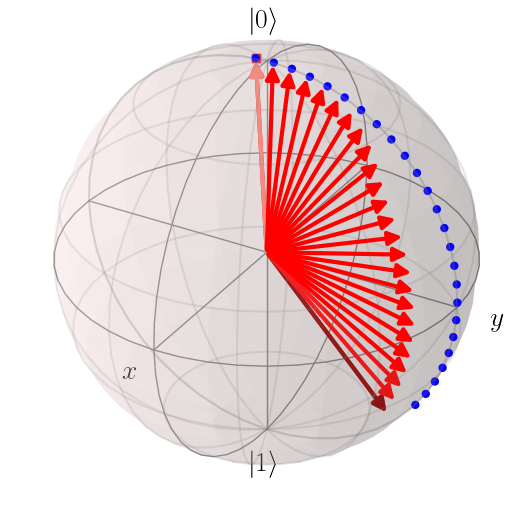

In [153]:
# First the decoupled system
# now generate the expected free oscillations
w = param_dict["t"]

# accounting for the different possible initial conditions
theta0 = 2*np.arccos(a0) 
times_coarse = np.linspace(0,max(times), len(dd_costheta))
theta_free = -theta0+2*w*times_coarse
phi_free = np.pi/2

# writting out free case solution in spherical coordinates
x_ = np.sin(theta_free)*np.cos(phi_free)
y_ = np.sin(theta_free)*np.sin(phi_free)
z_ = np.cos(theta_free)

# the + pi in the angle is because we start the system in the 1 state instead of the 0 
free_points = [x_, y_, z_]
free_first= [x_[0], y_[0], z_[0]]

# Now plot the numerical coupled case
dd_theta = np.arccos(dd_costheta)
dd_phi = np.arcsin(dd_sinphi)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*np.sin(dd_phi)
z_ = dd_costheta

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

bs = Bloch()

bs.add_points(free_points)
bs.add_points(free_first)

bs.add_vectors(coupled_vectors)
# now plot the first and last vectors and points in a different color

bs.add_vectors(coupled_vectors[0])
bs.add_vectors(coupled_vectors[-1])

bs.vector_color = ["red"]*len(coupled_vectors) + ["salmon", "darkred"]

bs.show()
bs.save(fig_route+"Bloch_sphere_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))

# Gaussian wavepacket

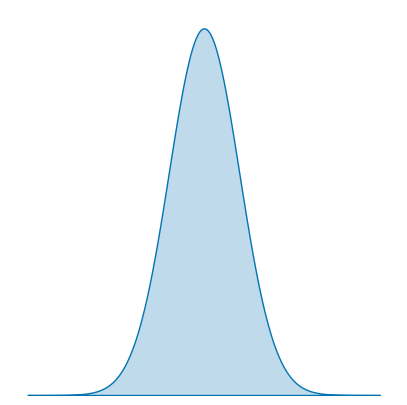

In [291]:
fig, ax = plt.subplots(1,1,figsize=(bheight,bheight))

GWP = np.random.normal(0, scale=1 , size=5000)

sns.kdeplot(GWP,fill=True,bw_adjust=5.0),

ax.set_xticks([])
ax.set_yticks([])

ax.spines[['right', 'top','bottom', 'left']].set_visible(False)
ax.set_ylabel("")

plt.savefig(fig_route+"gaussian_dist.pdf", transparent=True)


5000